In [2]:
import matplotlib as mpl
from matplotlib import font_manager

# 사용할 폰트 후보
font_candidates = ["Malgun Gothic", "NanumGothic", "AppleGothic", "Noto Sans CJK KR"]

for f in font_candidates:
    if f in [x.name for x in font_manager.fontManager.ttflist]:
        mpl.rc("font", family=f)
        break

mpl.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지

[INFO] 최근 7일 최다 병목 Queue = Warehouse1_Queue
[INFO] 병목 Cell = c_Cell1

[최근 Cell×SKU 생산량]
SKU           1      2      3      4
Cell                                
c_Cell1  118128  90100      0  30625
c_Cell2       0  23574      0  36195
c_Cell3       0   9860  32860      0
c_Cell4       0      0  81721  53959

[재분배 후 Cell×SKU 생산량]
SKU           1      2      3      4
Cell                                
c_Cell1  118128      0      0      0
c_Cell2       0  68624      0  51508
c_Cell3       0  54910  32860      0
c_Cell4       0      0  81721  69272

[재분배 전후 Cell별 Queue 변화]
         Before     After
Cell                     
c_Cell1  238853  118128.0
c_Cell2   59769  120131.5
c_Cell3   42720   87770.0
c_Cell4  135680  150992.5


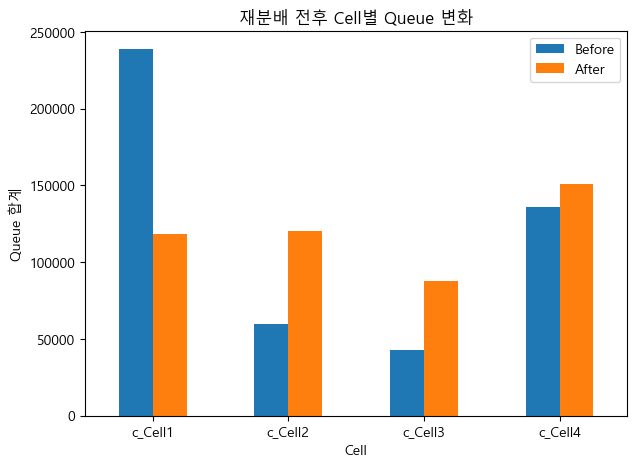

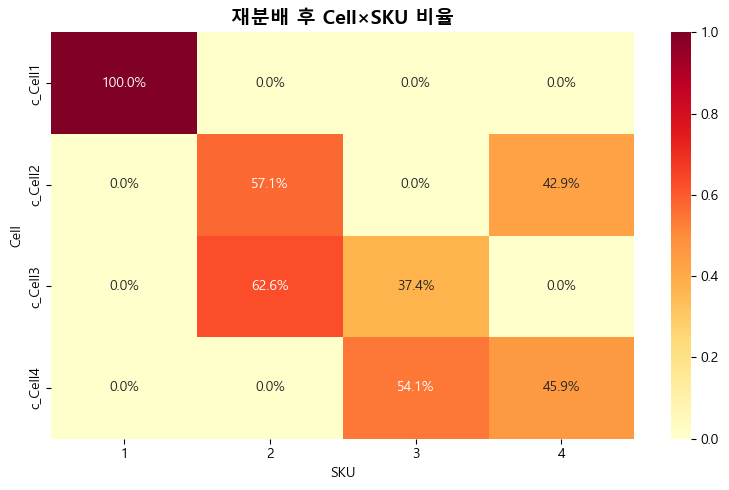

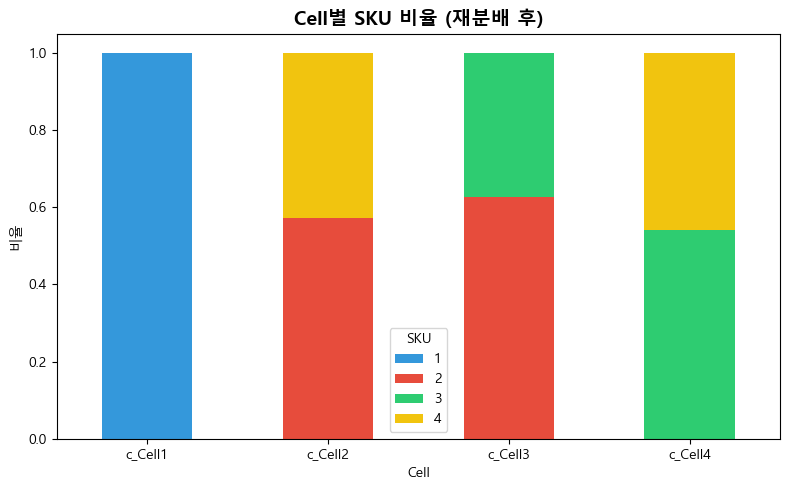

In [3]:
# -*- coding: utf-8 -*-
"""
병목 Cell 발생 시 SKU 재분배 시뮬레이션
- 최근 7일 데이터 기준 병목 Cell 추출
- Cell×SKU 생산량 pivot 집계
- 단순 분배 규칙으로 재분배 시뮬레이션
- 전후 비교 + 시각화
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 1. 데이터 로드
# ==========================
CSV_PATH = "subset_20240101_20250630_fullcols.csv"
df = pd.read_csv(CSV_PATH, low_memory=False)

# 시간 처리
df["Time_Now"] = pd.to_datetime(df["Time_Now"], errors="coerce")
df["_date"] = df["Time_Now"].dt.floor("D")
df = df.sort_values("Time_Now").reset_index(drop=True)

# Queue 컬럼 탐색
queue_cols = [c for c in df.columns if "Queue" in c]

# ==========================
# 2. 최근 7일 병목 Cell 탐지
# ==========================
date_bneck = []
for d, g in df.groupby("_date"):
    row_bneck = g[queue_cols].astype(float).idxmax(axis=1)
    top = row_bneck.value_counts().idxmax()
    date_bneck.append((d, top))

date_bneck = pd.DataFrame(date_bneck, columns=["date", "bneck"])
recent_bneck = date_bneck.tail(7)
print("[INFO] 최근 7일 최다 병목 Queue =", recent_bneck["bneck"].value_counts().idxmax())

# Cell 매핑
bneck_queue = recent_bneck["bneck"].value_counts().idxmax()
if "Warehouse1_Queue" in bneck_queue:   bneck_cell = "c_Cell1"
elif "Warehouse2_Queue" in bneck_queue: bneck_cell = "c_Cell2"
elif "Warehouse3_Queue" in bneck_queue: bneck_cell = "c_Cell3"
elif "Warehouse4_Queue" in bneck_queue: bneck_cell = "c_Cell4"
else: bneck_cell = None
print("[INFO] 병목 Cell =", bneck_cell)

# ==========================
# 3. 최근 7일 Cell×SKU 집계
# ==========================
cell_sku_cols = [c for c in df.columns if c.startswith("c_Cell")]
df_recent = df[df["_date"] >= df["_date"].max() - pd.Timedelta(days=7)]
pivot = df_recent[cell_sku_cols].sum().reset_index()
pivot.columns = ["col", "value"]
pivot["Cell"] = pivot["col"].str.extract(r"(c_Cell\d+)")
pivot["SKU"]  = pivot["col"].str.extract(r"SKU(\d+)")

cell_sku_pivot = pivot.pivot_table(
    index="Cell", columns="SKU", values="value", aggfunc="sum"
).fillna(0).astype(int)

print("\n[최근 Cell×SKU 생산량]")
print(cell_sku_pivot)

# ==========================
# 4. 재분배 시뮬레이션
# ==========================
# Cell ↔ SKU 매핑
cell_sku_map = {
    "c_Cell1": [1, 2, 4],
    "c_Cell2": [2, 4],
    "c_Cell3": [2, 3],
    "c_Cell4": [3, 4],
}

redistributed = cell_sku_pivot.astype(float).copy()

if bneck_cell:
    sku_dist = cell_sku_pivot.loc[bneck_cell]
    for sku, qty in sku_dist.items():
        if qty == 0:
            continue
        # 이 SKU를 처리할 수 있는 다른 Cell 후보
        eligible_cells = [c for c, skus in cell_sku_map.items()
                          if (int(sku) in skus and c != bneck_cell)]
        if not eligible_cells:
            continue

        # 균등 분배
        share = qty / len(eligible_cells)

        # 원래 병목 Cell에서 빼고
        redistributed.loc[bneck_cell, sku] -= qty
        # 다른 Cell에 나눠줌
        for c in eligible_cells:
            redistributed.loc[c, sku] += share

print("\n[재분배 후 Cell×SKU 생산량]")
print(redistributed.round().astype(int))

# ==========================
# 5. 전후 Queue 비교
# ==========================
before = cell_sku_pivot.sum(axis=1).rename("Before")
after  = redistributed.sum(axis=1).rename("After")
compare = pd.concat([before, after], axis=1)
print("\n[재분배 전후 Cell별 Queue 변화]")
print(compare)

# ==========================
# 6. 시각화
# ==========================
# (1) Before vs After bar chart
compare.plot(kind="bar", figsize=(7,5))
plt.title("재분배 전후 Cell별 Queue 변화")
plt.ylabel("Queue 합계")
plt.xticks(rotation=0)
plt.show()

# (2) Heatmap (재분배 후 Cell×SKU 비율)
cell_sku_ratio = redistributed.div(redistributed.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(8,5))
sns.heatmap(cell_sku_ratio, annot=True, cmap="YlOrRd", fmt=".1%", cbar=True)
plt.title("재분배 후 Cell×SKU 비율", fontsize=14, fontweight="bold")
plt.xlabel("SKU")
plt.ylabel("Cell")
plt.tight_layout()
plt.show()

# (3) Stacked Bar Chart
cell_sku_ratio.plot(kind="bar", stacked=True, figsize=(8,5),
                    color=["#3498db","#e74c3c","#2ecc71","#f1c40f"])
plt.title("Cell별 SKU 비율 (재분배 후)", fontsize=14, fontweight="bold")
plt.ylabel("비율")
plt.xticks(rotation=0)
plt.legend(title="SKU")
plt.tight_layout()
plt.show()